In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os
import cv2
import PIL

In [2]:
IMAGE_SIZE=(256,256)
BATCH_SIZE=32
CHANNEL=3
EPOCHS=30

In [3]:
img_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=32
)

Found 4627 files belonging to 5 classes.


In [4]:
class_names=img_dataset.class_names

In [5]:
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

32 32


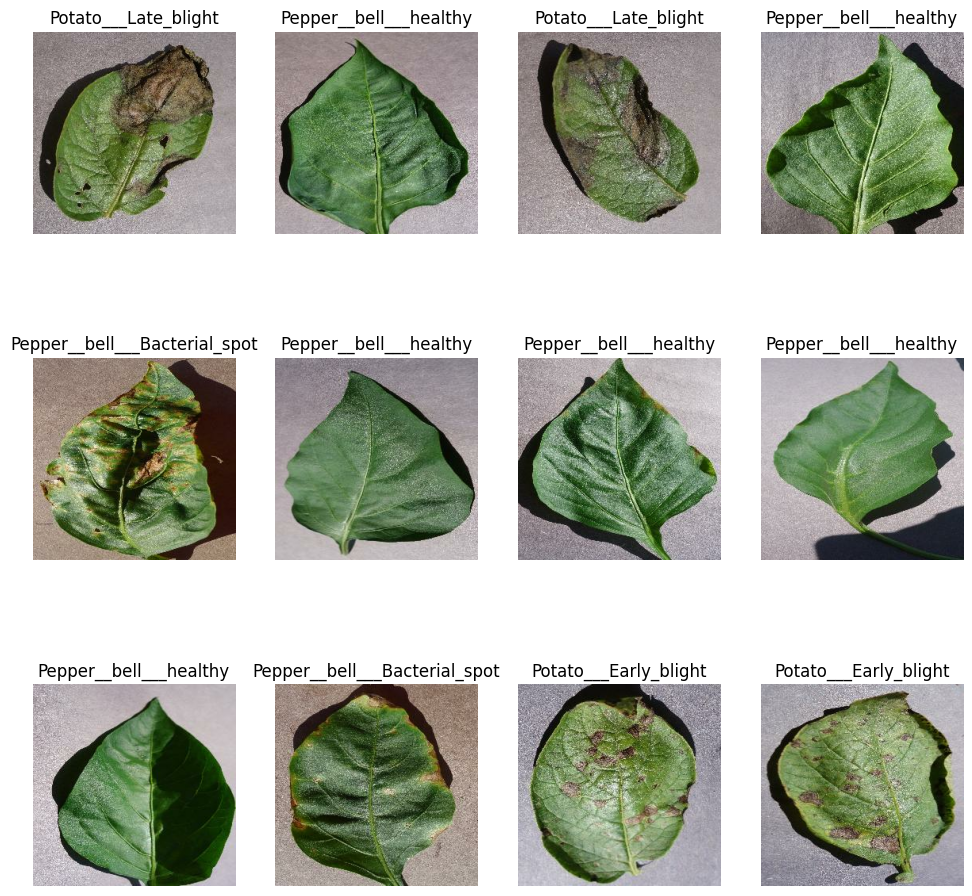

In [6]:
plt.figure(figsize=(12,12))
for img_batch,label_batch in img_dataset.take(1):
    print(len(img_batch),len(label_batch))
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
len(img_dataset)

145

In [8]:
'''80% Training
10% Validation
10% Testing'''

'80% Training\n10% Validation\n10% Testing'

In [28]:
train_size=0.8
145*0.8

116.0

In [29]:
train_ds=img_dataset.take(116)

In [30]:
test_ds=img_dataset.skip(116)

In [31]:
len(test_ds)


29

In [32]:
0.1*145 

14.5

In [33]:
val_ds=test_ds.take(14)
len(val_ds)

14

In [34]:
test_ds=test_ds.skip(14)
len(test_ds)

15

In [35]:
def train_test_split_tf(dataset,train_size=0.8,val_size=0.1,test_size=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    ds_size=len(dataset)
    train_ds=dataset.take(int(train_size*ds_size))
    train_ds_size=int(len(train_ds))
    
    val_ds=dataset.skip(int(train_ds_size)).take(int(val_size*ds_size))
    val_ds_size=int(len(val_ds))
    test_ds=dataset.skip(int(train_ds_size)).skip(val_ds_size)
    
    return train_ds,val_ds,test_ds

In [36]:
train_ds,val_ds,test_ds=train_test_split_tf(img_dataset)

In [37]:
len(train_ds)

116

In [38]:
len(val_ds)

14

In [39]:
len(test_ds)

15

In [40]:
#prefetch is used to select next data if current is in progress
# when gpu is training batch 1 cpu will load batch 2 to improve performance

In [41]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
#Here Though all the images are in 256,256 if we supply another image which is not in this pixels it will resize it to 256,256

In [43]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE[0],IMAGE_SIZE[0]),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [44]:
# let us also use data augumentation to train our model more precisely

In [45]:
data_augumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomRotation(0.3)
])

In [50]:
n_classes=5
ip_shape=(BATCH_SIZE,IMAGE_SIZE[0],IMAGE_SIZE[1],CHANNEL)
model=models.Sequential([
    resize_and_rescale,
    data_augumentation,
    
    layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=ip_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation="relu"), #softmax will normalize the probability of a classes
    layers.Dense(n_classes,activation="softmax")
])

model.build(input_shape=ip_shape)

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [52]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [53]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=val_ds)

Epoch 1/30
116/116 [==============================] - 122s 1s/step - loss: 1.3213 - accuracy: 0.4215 - val_loss: 1.1520 - val_accuracy: 0.5310
Epoch 2/30
116/116 [==============================] - 134s 1s/step - loss: 0.8444 - accuracy: 0.6621 - val_loss: 0.6722 - val_accuracy: 0.7379
Epoch 3/30
116/116 [==============================] - 145s 1s/step - loss: 0.5819 - accuracy: 0.7810 - val_loss: 0.4521 - val_accuracy: 0.8368
Epoch 4/30
116/116 [==============================] - 119s 1s/step - loss: 0.3937 - accuracy: 0.8659 - val_loss: 0.3323 - val_accuracy: 0.8782
Epoch 5/30
116/116 [==============================] - 112s 962ms/step - loss: 0.3304 - accuracy: 0.8867 - val_loss: 0.2999 - val_accuracy: 0.8897
Epoch 6/30
116/116 [==============================] - 86s 742ms/step - loss: 0.2954 - accuracy: 0.8975 - val_loss: 0.2470 - val_accuracy: 0.9103
Epoch 7/30
116/116 [==============================] - 69s 592ms/step - loss: 0.2252 - accuracy: 0.9227 - val_loss: 0.2896 - val_accuracy:

In [54]:
model.evaluate(test_ds)

15/15 [==============================] - 5s 146ms/step - loss: 0.0840 - accuracy: 0.9771


[0.0840349867939949, 0.9770833253860474]

In [55]:
history

In [56]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 116}

In [57]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


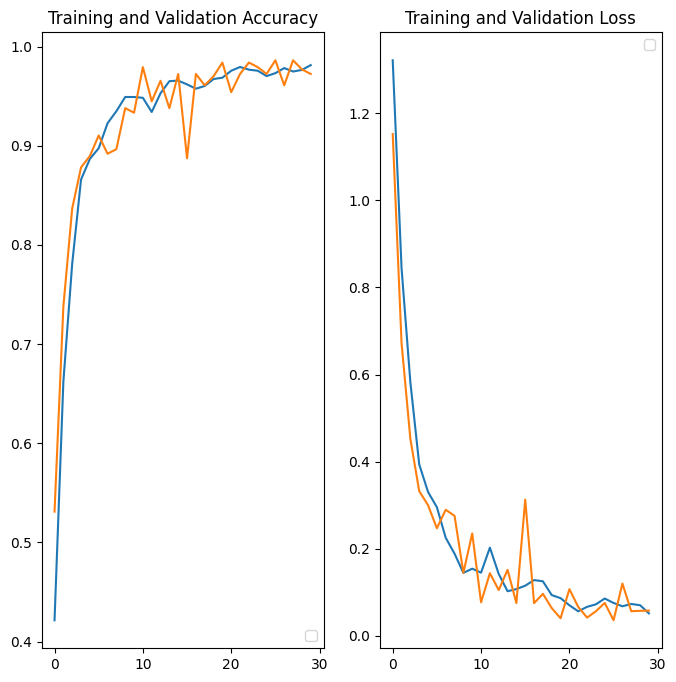

In [58]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc)
plt.plot(range(EPOCHS),val_acc)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss)
plt.plot(range(EPOCHS),val_loss)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

Actual
Predicted
1/1 [==============================] - 0s 254ms/step
Potato___Late_blight


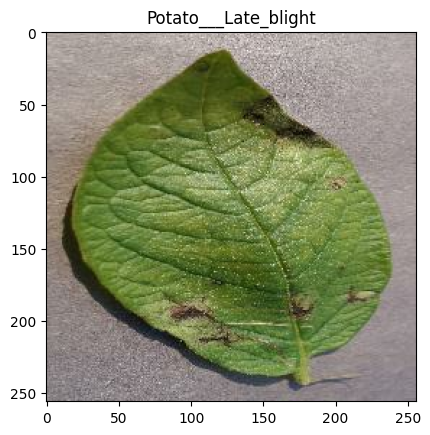

In [61]:
import numpy as np
for img_batch,label_batch in test_ds.take(1):
    print("Actual")
    img=img_batch[0].numpy().astype("uint8")
    label=label_batch[0].numpy().astype("uint8")
    plt.imshow(img)
    plt.title(class_names[label])
    
    print("Predicted")
    
    y_preds=model.predict(img_batch)
    y_preds_final=[np.argmax(i) for i in y_preds]
    print(class_names[y_preds_final[0]])

In [62]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
